# Introdução à Ciência de Dados 2023.1 - Trabalho 3 (Algoritmos de aprendizagem de máquina)
## Natã Lael Gomes Raulino // 549500

### Introdução

#### Steam
É uma das lojas virtuais de jogos para computadores mais populares atualmente, oferecendo jogos de diversos estúdios, publicadoras, gêneros etc. Nessa loja é possível encontrar desde jogos AAA até produções independentes de baixíssimo custo.
![Tela de busca da Steam](steam_img.png)

#### SteamDB
É (como o nome sugere) uma base de dados relacionada aos jogos disponibilizados na plataforma Steam. Eles agregam diversas informações, como os preços dos jogos em diversos países, dados sobre atualizações, DLCs, catalogação na loja etc.
![Tela inicial da SteamDB](steamdb_img1.jpg)

#### Coleta de dados
Foi realizada combinando informações obtidas através de webscrapping na SteamDB e utilizando a API da Steam
- AppID do jogo (SDB)
- Título do jogo (SDB)
- Mês de lançamento (SDB)
- Score (SDB)
- Pico de jogadores ativos (SDB)
- Total de reviews (SDB)
- Preço atual do jogo (API da Steam)
- Gêneros/tags dos jogos (API da Steam)

#### Importando recursos comuns

In [35]:
!pip install catboost
import pandas as pd
import numpy as np
import pylab as py
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import statsmodels.api as sm
import math

### Preparando os dados
#### Lendo o arquivo CSV utilizando apenas as informações que serão utilizadas nos algoritmos de <i>machine learning</i>

In [36]:
df = pd.read_csv('dataset_steam.csv', header=0)
df.head()

,appid,name,release_month,peak_players,total_reviews,price,acesso antecipado,aventura,ação,casual,corrida,esportes,estratégia,gratuito p/ jogar,indie,multijogador massivo,rpg,simulação,positive
0,1245620,ELDEN RING,2,953426,684522,249.90,False,False,True,False,False,False,False,False,False,False,True,False,1
1,1938090,Call of Duty®: Modern Warfare® II | Warzone™,10,491670,397437,299.90,False,False,True,False,False,False,False,False,False,False,False,False,1
2,648800,Raft,6,101096,273463,36.99,False,True,False,False,False,False,False,False,True,False,False,True,1
3,261550,Mount & Blade II: Bannerlord,10,248216,223617,199.99,False,False,True,False,False,False,True,False,True,False,True,True,1
4,1794680,Vampire Survivors,10,77061,199727,12.99,False,False,True,True,False,False,False,False,True,False,True,False,1


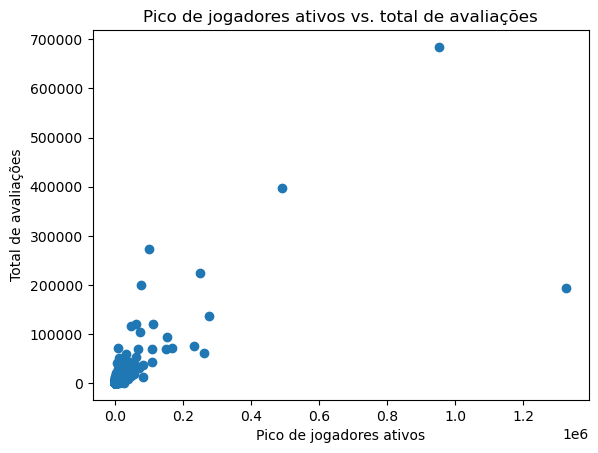

In [37]:
plt.scatter(df['peak_players'], df['total_reviews'])
plt.xlabel('Pico de jogadores ativos')
plt.ylabel('Total de avaliações')
plt.title('Pico de jogadores ativos vs. total de avaliações')
plt.show()

#### Selecionando apenas as <i>features</i> que serão utilizadas pelos modelos de ML

In [38]:
df = df[['release_month', 'peak_players', 'total_reviews', 'price', 'acesso antecipado', 'aventura', 'ação', 'casual', 'corrida', 'esportes', 'estratégia', 'gratuito p/ jogar', 'indie', 'multijogador massivo', 'rpg', 'simulação', 'positive']]

# Convertendo colunas booleanas para 1/0
boolean_columns = df.select_dtypes(include=bool).columns
df_boolean = df.copy()
df_boolean[boolean_columns] = df_boolean[boolean_columns].astype(int)
df = df_boolean

df.head()

,release_month,peak_players,total_reviews,price,acesso antecipado,aventura,ação,casual,corrida,esportes,estratégia,gratuito p/ jogar,indie,multijogador massivo,rpg,simulação,positive
0,2,953426,684522,249.90,0,0,1,0,0,0,0,0,0,0,1,0,1
1,10,491670,397437,299.90,0,0,1,0,0,0,0,0,0,0,0,0,1
2,6,101096,273463,36.99,0,1,0,0,0,0,0,0,1,0,0,1,1
3,10,248216,223617,199.99,0,0,1,0,0,0,1,0,1,0,1,1,1
4,10,77061,199727,12.99,0,0,1,1,0,0,0,0,1,0,1,0,1


#### Verificando o quão bem representadas estão as duas classes

In [39]:
positive_reviews = df['positive'].sum()
negative_reviews = len(df) - positive_reviews

positive_proportion = positive_reviews / len(df)
negative_proportion = negative_reviews / len(df)

print(f"Reviews positivas: {positive_reviews} // {(positive_proportion*100).round(2)}%")
print(f"Reviews negativas: {negative_reviews} // {(negative_proportion*100).round(2)}%")

Reviews positivas: 589 // 97.52%
Reviews negativas: 15 // 2.48%


#### Verificando a importância de cada <i>feature</i>  para a classe final

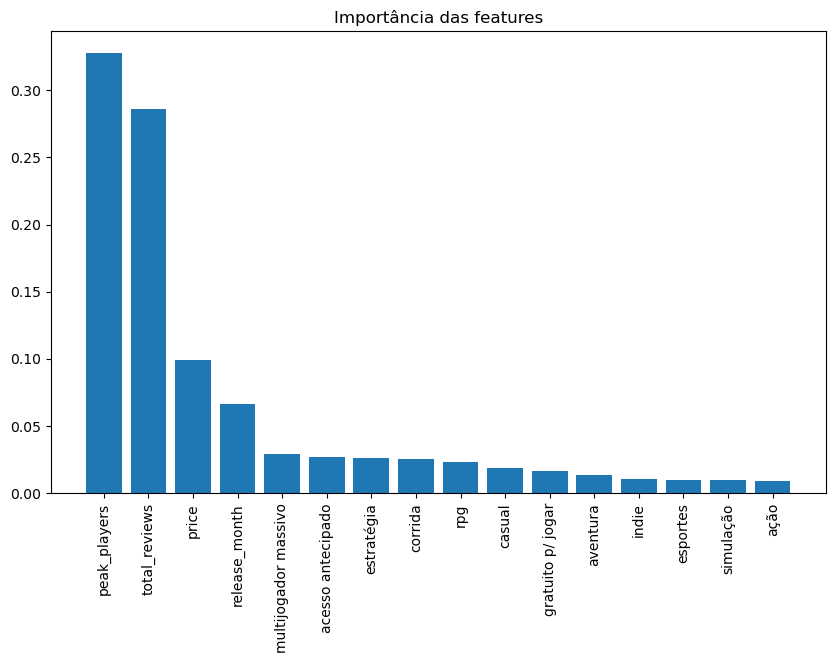

In [40]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

features = df[['release_month', 'peak_players', 'total_reviews', 'price', 'acesso antecipado', 'aventura', 'ação', 'casual', 'corrida', 'esportes', 'estratégia', 'gratuito p/ jogar', 'indie', 'multijogador massivo', 'rpg', 'simulação']]
target = df['positive']

regressor = RandomForestRegressor()
regressor.fit(features, target)

importances = regressor.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importância das features")
plt.bar(range(features.shape[1]), importances[indices])
plt.xticks(range(features.shape[1]), features.columns[indices], rotation=90)
plt.show()

#### Separando os dados em treino e teste

In [51]:
from sklearn.model_selection import train_test_split

X = df[['release_month', 'peak_players', 'total_reviews', 'price', 'acesso antecipado', 'aventura', 'ação', 'casual', 'corrida', 'esportes', 'estratégia', 'gratuito p/ jogar', 'indie', 'multijogador massivo', 'rpg', 'simulação']]
y = df['positive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Normalizando os dados

In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Selecionando apenas as colunas não-categóricas para normalizar
columns_to_scale = ['release_month', 'peak_players', 'total_reviews', 'price']

# Definindo os parâmetros de normalização a partir dos dados de treino
scaler.fit(X_train[columns_to_scale])

# Normalizando os dados com os parâmetros dos dados de treino 
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

### Aplicando algoritmos de aprendizagem de máquina - Abordagem de classificação binária tradicional

#### Regressão logística

Acurácia da regressão logística: 0.9669421487603306


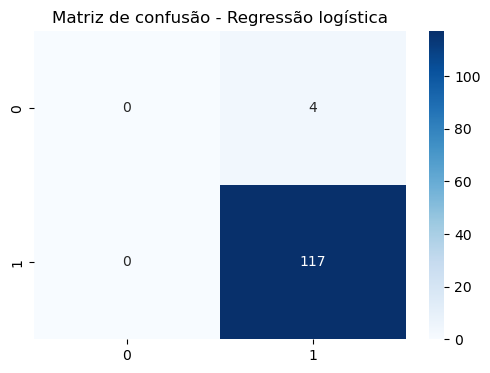

In [43]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()
logReg.fit(X_train, y_train)

y_pred = logReg.predict(X_test)

lr_accuracy = accuracy_score(y_test, y_pred)

print(f'Acurácia da regressão logística: {lr_accuracy}')

lr_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusão - Regressão logística")
plt.show()

#### Árvore de decisão

Acurácia da árvore de decisão: 0.9586776859504132


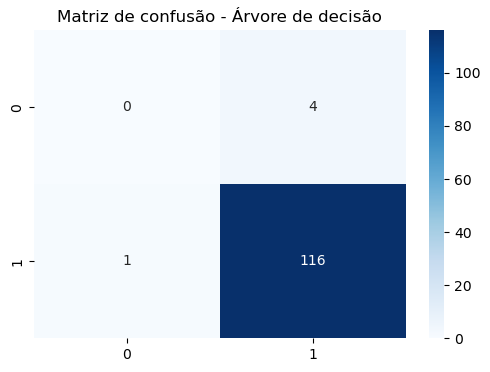

In [44]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

dtc_accuracy = accuracy_score(y_test, y_pred)

print(f'Acurácia da árvore de decisão: {dtc_accuracy}')

dtc_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(dtc_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusão - Árvore de decisão")
plt.show()

#### Random Forest

Acurácia da Random Forest: 0.9669421487603306


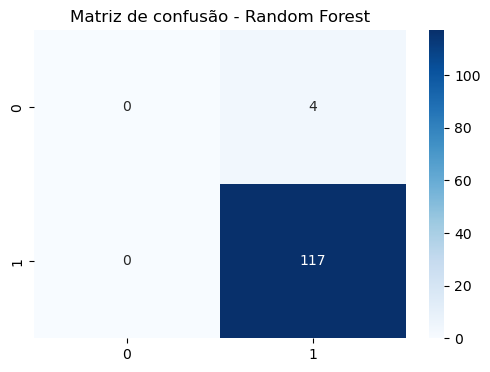

In [45]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

rfc_accuracy = accuracy_score(y_test, y_pred)

print(f'Acurácia da Random Forest: {rfc_accuracy}')

rfc_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(rfc_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusão - Random Forest")
plt.show()

#### Support Vector Classifier

Acurácia do Support Vector Classifier: 0.9669421487603306


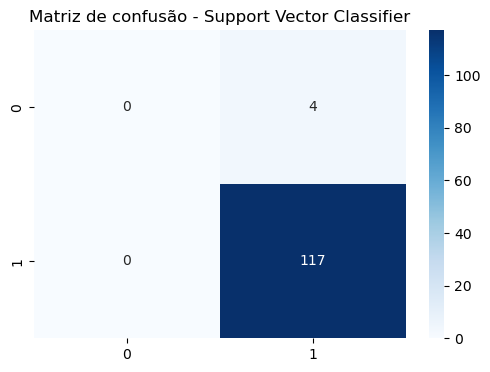

In [46]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train, y_train)

y_pred = svc_model.predict(X_test)

svc_accuracy = accuracy_score(y_test, y_pred)

print(f'Acurácia do Support Vector Classifier: {svc_accuracy}')

svc_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(svc_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusão - Support Vector Classifier")
plt.show()

#### CatBoost

0:	learn: 0.6239128	total: 1.33ms	remaining: 132ms
1:	learn: 0.5704309	total: 2.66ms	remaining: 130ms
2:	learn: 0.5106606	total: 3.08ms	remaining: 99.6ms
3:	learn: 0.4677112	total: 4.35ms	remaining: 104ms
4:	learn: 0.4296092	total: 5.6ms	remaining: 106ms
5:	learn: 0.3998381	total: 6.7ms	remaining: 105ms
6:	learn: 0.3690054	total: 7.71ms	remaining: 102ms
7:	learn: 0.3484979	total: 8.72ms	remaining: 100ms
8:	learn: 0.3206436	total: 9.27ms	remaining: 93.8ms
9:	learn: 0.3010197	total: 10.3ms	remaining: 93.1ms
10:	learn: 0.2856324	total: 11.3ms	remaining: 91.7ms
11:	learn: 0.2699191	total: 12.4ms	remaining: 91.1ms
12:	learn: 0.2540606	total: 13.5ms	remaining: 90.1ms
13:	learn: 0.2413543	total: 14.5ms	remaining: 89.2ms
14:	learn: 0.2294376	total: 15.5ms	remaining: 88ms
15:	learn: 0.2188322	total: 16.6ms	remaining: 87.2ms
16:	learn: 0.2083832	total: 17.6ms	remaining: 85.8ms
17:	learn: 0.2008407	total: 18.6ms	remaining: 84.7ms
18:	learn: 0.1924106	total: 19.7ms	remaining: 84ms
19:	learn: 0.187

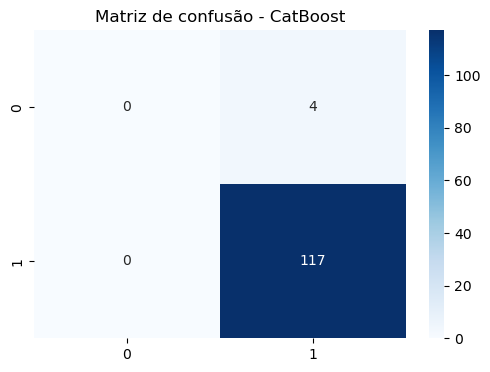

In [47]:
from catboost import CatBoostClassifier

cbc = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6)
cbc.fit(X_train, y_train)

y_pred = cbc.predict(X_test)

cbc_accuracy = accuracy_score(y_test, y_pred)

print(f'Acurácia do CatBoost: {cbc_accuracy}')

cbc_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cbc_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusão - CatBoost")
plt.show()

### Tentando balancear os dados

In [67]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
Xr, yr = smote.fit_resample(X, y)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)

#### Normalizando os dados balanceados

In [68]:
scaler = MinMaxScaler()

# Selecionando apenas as colunas não-categóricas para normalizar
columns_to_scale = ['release_month', 'peak_players', 'total_reviews', 'price']

# Definindo os parâmetros de normalização a partir dos dados de treino
scaler.fit(Xr_train[columns_to_scale])

# Normalizando os dados com os parâmetros dos dados de treino 
Xr_train[columns_to_scale] = scaler.transform(Xr_train[columns_to_scale])
Xr_test[columns_to_scale] = scaler.transform(Xr_test[columns_to_scale])

#### Regressão logística

Acurácia da regressão logística: 0.8940677966101694


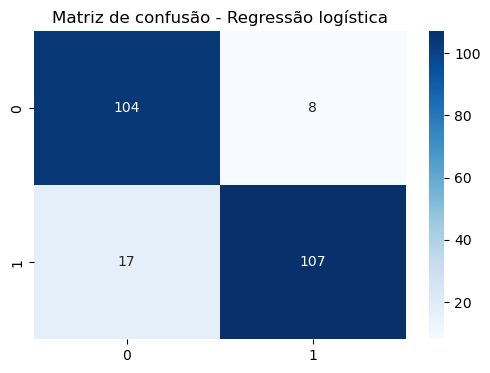

In [76]:
logReg = LogisticRegression()
logReg.fit(Xr_train, yr_train)

yr_pred = logReg.predict(Xr_test)

lr_accuracy = accuracy_score(yr_test, yr_pred)

print(f'Acurácia da regressão logística: {lr_accuracy}')

lr_cm = confusion_matrix(yr_test, yr_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusão - Regressão logística")
plt.show()

#### Árvorede decisão

Acurácia da árvore de decisão: 0.9533898305084746


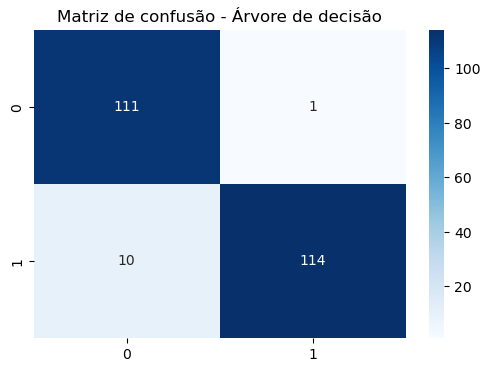

In [69]:
dtc = DecisionTreeClassifier()
dtc.fit(Xr_train, yr_train)

yr_pred = dtc.predict(Xr_test)

dtc_accuracy = accuracy_score(yr_test, yr_pred)

print(f'Acurácia da árvore de decisão: {dtc_accuracy}')

dtc_cm = confusion_matrix(yr_test, yr_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(dtc_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusão - Árvore de decisão")
plt.show()

#### Random Forest

Acurácia da Random Forest: 0.9703389830508474


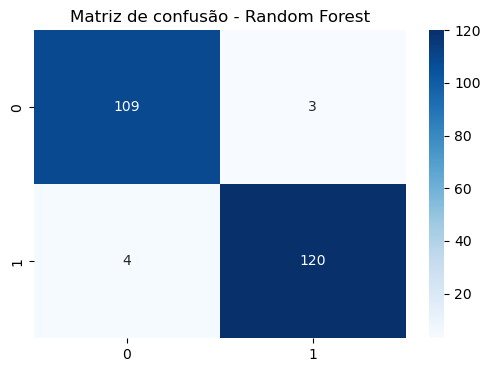

In [72]:
rfc = RandomForestClassifier()
rfc.fit(Xr_train, yr_train)

yr_pred = rfc.predict(Xr_test)

rfc_accuracy = accuracy_score(yr_test, yr_pred)

print(f'Acurácia da Random Forest: {rfc_accuracy}')

rfc_cm = confusion_matrix(yr_test, yr_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(rfc_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusão - Random Forest")
plt.show()

#### Support Vector Classifier

Acurácia do Support Vector Classifier: 0.923728813559322


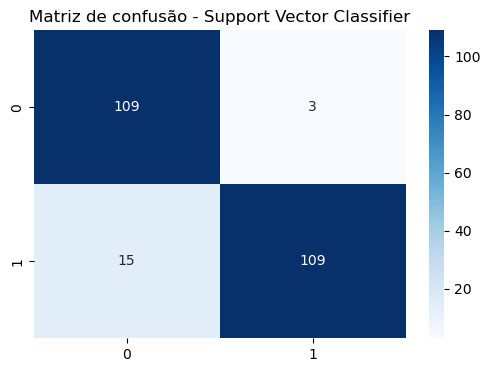

In [74]:
svc_model = SVC()
svc_model.fit(Xr_train, yr_train)

yr_pred = svc_model.predict(Xr_test)

svc_accuracy = accuracy_score(yr_test, yr_pred)

print(f'Acurácia do Support Vector Classifier: {svc_accuracy}')

svc_cm = confusion_matrix(yr_test, yr_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(svc_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusão - Support Vector Classifier")
plt.show()

#### CatBoost

0:	learn: 0.6520258	total: 14.4ms	remaining: 1.43s
1:	learn: 0.6208446	total: 16.1ms	remaining: 789ms
2:	learn: 0.5943604	total: 17.6ms	remaining: 568ms
3:	learn: 0.5668373	total: 18.9ms	remaining: 454ms
4:	learn: 0.5461006	total: 20.3ms	remaining: 385ms
5:	learn: 0.5231536	total: 21.7ms	remaining: 339ms
6:	learn: 0.5058353	total: 23ms	remaining: 306ms
7:	learn: 0.4862145	total: 24.5ms	remaining: 282ms
8:	learn: 0.4677870	total: 26.3ms	remaining: 266ms
9:	learn: 0.4501937	total: 27.7ms	remaining: 249ms
10:	learn: 0.4351031	total: 29ms	remaining: 234ms
11:	learn: 0.4209366	total: 30.4ms	remaining: 223ms
12:	learn: 0.4102566	total: 31.8ms	remaining: 213ms
13:	learn: 0.3986163	total: 33.1ms	remaining: 203ms
14:	learn: 0.3890526	total: 34.4ms	remaining: 195ms
15:	learn: 0.3788231	total: 35.7ms	remaining: 188ms
16:	learn: 0.3698349	total: 37ms	remaining: 181ms
17:	learn: 0.3596845	total: 38.3ms	remaining: 175ms
18:	learn: 0.3516099	total: 39.7ms	remaining: 169ms
19:	learn: 0.3452681	total: 

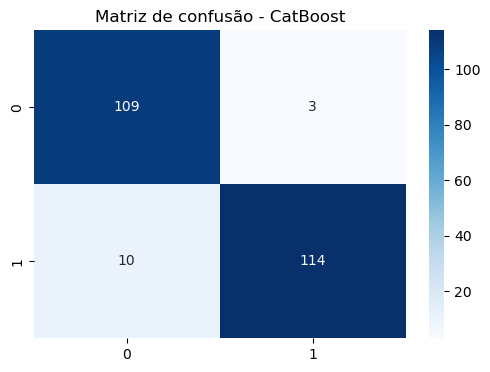

In [77]:
cbc = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6)
cbc.fit(Xr_train, yr_train)

yr_pred = cbc.predict(Xr_test)

cbc_accuracy = accuracy_score(yr_test, yr_pred)

print(f'Acurácia do CatBoost: {cbc_accuracy}')

cbc_cm = confusion_matrix(yr_test, yr_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cbc_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusão - CatBoost")
plt.show()